# PPP-adjusted salary comparator

## Function automation

Firstly, we intend to automate the translation of the selected countries (because Datosmacro is a Spanish website of the newspaper Expansion); secondly, we'll automate the extraction of the data and, finally, the transformation of the data into a clean DataFrame that we'll use to visualise these comparisons (although we'll have them more detailed in the DataFrame created first, of course).

In [1]:
import pandas as pd

import requests

from bs4 import BeautifulSoup

import matplotlib.pyplot as plt

from deep_translator import GoogleTranslator

from unidecode import unidecode

from time import sleep

import mysql.connector

In [2]:
def translator(country1, country2):
    
    translator = GoogleTranslator(source='en', target='es') # Automate translation from the Google translator
    
    country1 = translator.translate(country1)
    country2 = translator.translate(country2)
    
    country1 = country1.lower()
    country1 = country1.capitalize()
    
    country2 = country2.lower()
    country2 = country2.capitalize()
    
    country1 = unidecode(country1)
    country2 = unidecode(country2)
        # By this, we make sure that the country selected respect the format of Datosmacro
    
    countries = list()
    countries.append(country1)
    countries.append(country2)
    
    return countries

In [3]:
def extraction(countries):
    url_1 = f"https://datosmacro.expansion.com/mercado-laboral/salario-medio/{countries[0].lower()}"
    url_2 = f"https://datosmacro.expansion.com/mercado-laboral/salario-medio/{countries[1].lower()}"
    
    response_1 = requests.get(url_1)
    
    sleep(1)
    
    response_2 = requests.get(url_2)
    
    soup_1 = BeautifulSoup(response_1.text, "html.parser")
    soup_2 = BeautifulSoup(response_2.text, "html.parser")
    
    mean_wage_1 = [soup_1.find_all("td", class_ = "numero")[i].text for i in range(len(soup_1.find_all("td", class_ = "numero")))]

    mean_wage_2 = [soup_2.find_all("td", class_ = "numero")[i].text for i in range(len(soup_2.find_all("td", class_ = "numero")))]
    
    mean_wage_1 = [mean_wage_1[i].split()[0] for i in range(len(mean_wage_1))]

    mean_wage_2 = [mean_wage_2[i].split()[0] for i in range(len(mean_wage_2))]
    
    mean_wage_1 = mean_wage_1[::3] # For some reason, the webpage returns a value that it's not on the mean wages table
    
    mean_wage_2 = mean_wage_2[::3] # However, the return follows a pattern. Therefore, every two values after the the first one and so on are deleted
    
    del mean_wage_1[-1] # Eurostat has data only referred to the PPP until 2021, but Datosmacro offers data for mean wages up to 2022
    
    del mean_wage_2[-1]
    
    mean_wage_1 = mean_wage_1[::-1] # The values are inverted, so that we can get, then, a DataFrame with the values in an ascending order by year
    
    mean_wage_2 = mean_wage_2[::-1]
    
    return [mean_wage_1, mean_wage_2]

In [4]:
def cleaning(country1, country2, wages):
    df = pd.read_excel("PPPs.xlsx", sheet_name= "Sheet 2") # The Excel is clean and prepared for the extraction

    df = df.set_index("TIME") # We set the years as the index, so that, at the moment of visualizing we'll be able to use df.index as the x-axis
    
    country1 = country1.lower()
    country2 = country2.lower()
    
    df = df.loc[:, [country1.capitalize(), country2.capitalize()]]
    
    wage1 = [float(i) for i in wages[0]]
    wage1 = [i*1000 for i in wage1]

    wage2 = [float(i) for i in wages[1]]
    wage2 = [i*1000 for i in wage2]
    
    df[f"Mean wage of {country1.capitalize()}"] = wage1
    df[f"Mean wage of {country2.capitalize()}"] = wage2
    
    df[f"What would you earn in {country2.capitalize()} with the power purchasing of {country1.capitalize()}"] = [round((df[f"Mean wage of {country1.capitalize()}"].iloc[i] * df[f"{country2.capitalize()}"].iloc[i])/(df[f"{country1.capitalize()}"].iloc[i]), 2) for i in range(len(df[f"Mean wage of {country1.capitalize()}"]))]
    df[f"What would you earn in {country1.capitalize()} with the power purchasing of {country2.capitalize()}"] = [round((df[f"Mean wage of {country2.capitalize()}"].iloc[i] * df[f"{country1.capitalize()}"].iloc[i])/(df[f"{country2.capitalize()}"].iloc[i]), 2) for i in range(len(df[f"Mean wage of {country2.capitalize()}"]))]
    
    return df

In [5]:
def graph(df, country_1, country_2):
    dates = [df.index[i] for i in range(len(df.index))]
    
    country_1 = country_1.lower()
    country_2 = country_2.lower()
    
    plt.figure(figsize = (16, 12))
    
    plt.subplot(3, 1, 1)
    plt.plot(dates, df[f"What would you earn in {country_2.capitalize()} with the power purchasing of {country_1.capitalize()}"], linestyle= '--', color= 'orange')
    plt.plot(dates, df[f"Mean wage of {country_2.capitalize()}"], linestyle= '-', color= 'blue')

    plt.grid()
    plt.xlabel("Years")
    plt.ylabel("Salary (adjusted, in euros)")
    plt.legend([f"What would you earn in {country_2.capitalize()} with the power purchasing of {country_1.capitalize()}", f"Mean wage in {country_2.capitalize()}"], loc= 'best', fontsize= 10)
    
    
    plt.subplot(3, 1, 2)
    plt.plot(dates, df[f"What would you earn in {country_1.capitalize()} with the power purchasing of {country_2.capitalize()}"], linestyle= '--', color= 'orange')
    plt.plot(dates, df[f"Mean wage of {country_1.capitalize()}"], linestyle= '-', color= 'blue')

    plt.grid()
    plt.xlabel("Years")
    plt.ylabel("Salary (adjusted, in euros)")
    plt.legend([f"What would you earn in {country_1.capitalize()} with the power purchasing of {country_2.capitalize()}", f"Mean wage in {country_1.capitalize()}"], loc= 'best', fontsize= 10)
    
    plt.subplot(3, 1, 3)
    plt.plot(dates, df[f"{country_1.capitalize()}"], linestyle= '-', color= 'orange')
    plt.plot(dates, df[f"{country_2.capitalize()}"], linestyle= '-', color= 'blue')

    plt.grid()
    plt.xlabel("Years")
    plt.ylabel("PPPs (actual individual expenditure)")
    plt.legend([f"PPPs of {country_1.capitalize()}", f"PPPs of {country_2.capitalize()}"], loc= 'best', fontsize= 12)

# Example. How to use it properly

Use two variables to store the countries you want to compare (you can simply run the whole code and use the code that was written below)

In [6]:
country1 = input("Select one country: ")
country2 = input("Select another country: ")

countries = translator(country1.lower(), country2.lower())

Select one country: italy
Select another country: france


Then, stores in another variable the wages for both countries

In [7]:
wages = extraction(countries)

Storing the DataFrame after using the "cleaning" function, so that you can view the DataFrame right after storing it.

In [8]:
df = cleaning(country1.capitalize(), country2.capitalize(), wages)

In [9]:
df

,Italy,France,Mean wage of Italy,Mean wage of France,What would you earn in France with the power purchasing of Italy,What would you earn in Italy with the power purchasing of France
TIME,,,,,,
2000,1.02839,1.09843,22182.0,27418.0,23692.74,25669.73
2001,1.04527,1.07734,22640.0,28185.0,23334.62,27346.00
2002,1.06640,1.07562,23113.0,28847.0,23312.83,28599.73
2003,1.06781,1.11141,23723.0,29608.0,24691.64,28446.49
2004,1.08193,1.12675,24450.0,30521.0,25462.86,29306.93
2005,1.08029,1.10418,25241.0,31369.0,25799.19,30690.30
2006,1.07116,1.11184,25805.0,32413.0,26785.01,31227.07
2007,1.06033,1.11167,26845.0,33580.0,28144.81,32029.18
2008,1.03872,1.12085,27419.0,34132.0,29586.98,31630.99


Finally, simply use the function "graph" and enjoy :)

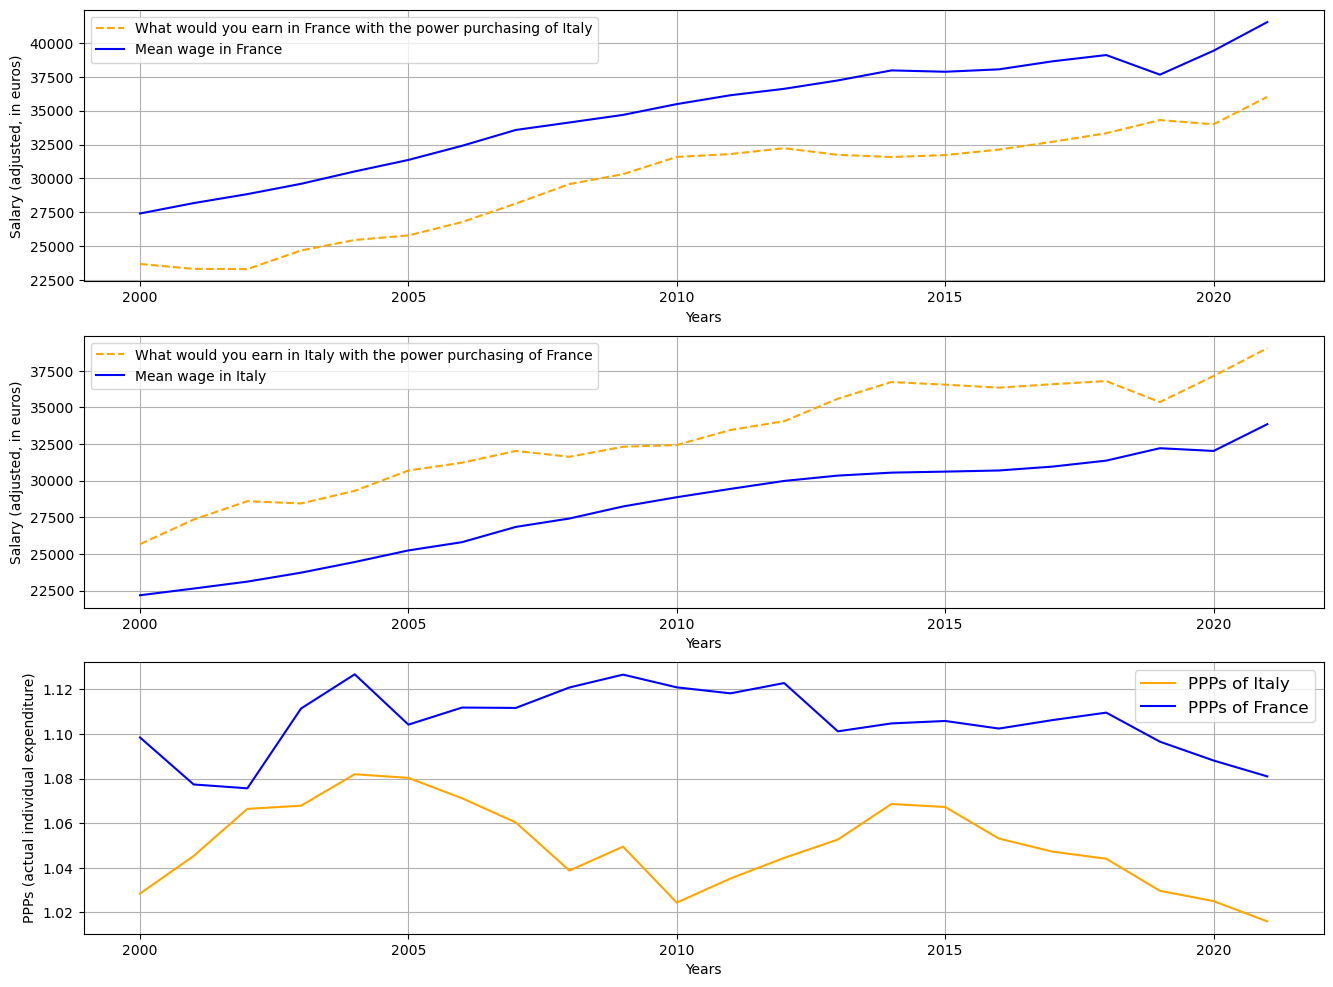

In [10]:
graph(df, country1.capitalize(), country2.capitalize())

### **************************************************************************************************************************************

# If you want to download the DataFrame as a CSV or Excel file

In [11]:
def download(df):
    formato = input("What format do you want? Excel or CSV: ")
    if formato.lower() == "excel":
        df.to_excel('Results.xlsx', index= True)
    else:
        df.to_csv('Results.csv', index= True)

In [12]:
download(df)

What format do you want? Excel or CSV: csv


### **************************************************************************************************************************************

# If you want to save it in a SQL database

In [13]:
def create_database():
    try:
        host = input("Select your host: ")
        user = input("Insert your user: ")
        password = input("Insert your password: ")
        database = input("Insert the name of the database: ")
        
        db = mysql.connector.connect(host=host, user=user, password=password, database=database)
        cursor = db.cursor()
        
        cursor.execute(f"CREATE DATABASE IF NOT EXISTS {database};")
        cursor.execute(f"USE {database};")
        
        query = f"CREATE TABLE {country1} ({country1}_id INT AUTO_INCREMENT PRIMARY KEY, mean_wage FLOAT(7, 2), PPP FLOAT(8, 4), adjusted_mean_wage FLOAT(7, 2));"
        cursor.execute(query)
        
        query = f"CREATE TABLE {country2} ({country2}_id INT AUTO_INCREMENT PRIMARY KEY, mean_wage FLOAT(7, 2), PPP FLOAT(8, 4), adjusted_mean_wage FLOAT(7, 2));"
        cursor.execute(query)
        
        db.commit()
        cursor.close()
        db.close()
        
        print("Database and tables created successfully!")
        
    except mysql.connector.Error as error:
        print("Error while connecting to MySQL:", error)
    except Exception as e:
        print("An error occurred:", e)

In [14]:
import mysql.connector

def insert_into_table(df):
    try:
        host = input("Select your host: ")
        user = input("Insert your user: ")
        password = input("Insert your password: ")
        database = input("Insert the name of the database: ")

        db = mysql.connector.connect(host=host, user=user, password=password, database=database)
        cursor = db.cursor()

        for index, row in df.iterrows():
            query = f"INSERT INTO {country1} (mean_wage, PPP, adjusted_mean_wage) VALUES ({row[f'Mean wage of {country1.capitalize()}']}, {row[f'{country1.capitalize()}']}, {row[f'What would you earn in {country1.capitalize()} with the power purchasing of {country2.capitalize()}']});"
            cursor.execute(query)

        for index, row in df.iterrows():
            query = f"INSERT INTO {country2} (mean_wage, PPP, adjusted_mean_wage) VALUES ({row[f'Mean wage of {country2.capitalize()}']}, {row[f'{country2.capitalize()}']}, {row[f'What would you earn in {country2.capitalize()} with the power purchasing of {country1.capitalize()}']});"
            cursor.execute(query)

        db.commit()
        cursor.close()
        db.close()

        print("Data inserted successfully!")

    except mysql.connector.Error as error:
        print("Error while connecting to MySQL:", error)
    except Exception as e:
        print("An error occurred:", e)

In [15]:
create_database()

Select your host: localhost
Insert your user: root
Insert your password: IAmSherlocked1!
Insert the name of the database: proyecto
Database and tables created successfully!


In [16]:
insert_into_table(df)

Select your host: localhost
Insert your user: root
Insert your password: IAmSherlocked1!
Insert the name of the database: proyecto
Data inserted successfully!
